In [1]:
# Carnegie Mellon University city temp dataset
# https://kilthub.cmu.edu/articles/dataset/Compiled_daily_temperature_and_precipitation_data_for_the_U_S_cities/7890488

In [2]:
from collections import defaultdict
from csv import DictReader
from datetime import datetime
from os.path import join
from pandas import to_datetime
from pprint import pprint
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import shapely.geometry as sgeom

In [3]:
directory = './cmu_dataset_7890488'
cities = {}
with open(join(directory, 'city_info.csv')) as fh:
    csv = DictReader(fh)
    for row in csv:
        cities[row['Stn.Name']] = row

In [4]:
len(cities)

430

In [5]:
for city in cities.values():
    with open(join(directory, f'{city["ID"]}.csv')) as fh:
        
        # Walk the historical temperature data and pull out the bits we need
        csv = DictReader(fh)
        tmaxes = []
        by_year = defaultdict(list)
        for row in csv:
            tmax = row['tmax']
            if tmax == 'NA':
                continue
            tmax = float(tmax)
            # find the 98th percentile temp
            year = int(row['Date'][:4])
            by_year[year].append(tmax)
            tmaxes.append(tmax)
            
        # Calculate the 98th percentile
        tmaxes.sort()
        p98 = tmaxes[int(len(tmaxes) * 0.98 + 90.5)]
        
        # Not assuming 
        for year, tmaxes in sorted(by_year.items()):
            count = 0
            for tmax in tmaxes:
                if tmax >= p98:
                    count += 1
            by_year[year] = count
            
        city['Lat'] = float(city['Lat'])
        city['Lon'] = float(city['Lon'])
        
        city['p98_by_year_m'], city['p98_by_year_b'] = \
            np.polyfit(list(by_year.keys()), list(by_year.values()), 1)
        
        city['p98'] = p98
        city['p98_by_year'] = dict(by_year)
        
cities = list(cities.values())
cities.sort(key=lambda c: c['p98_by_year_m'])

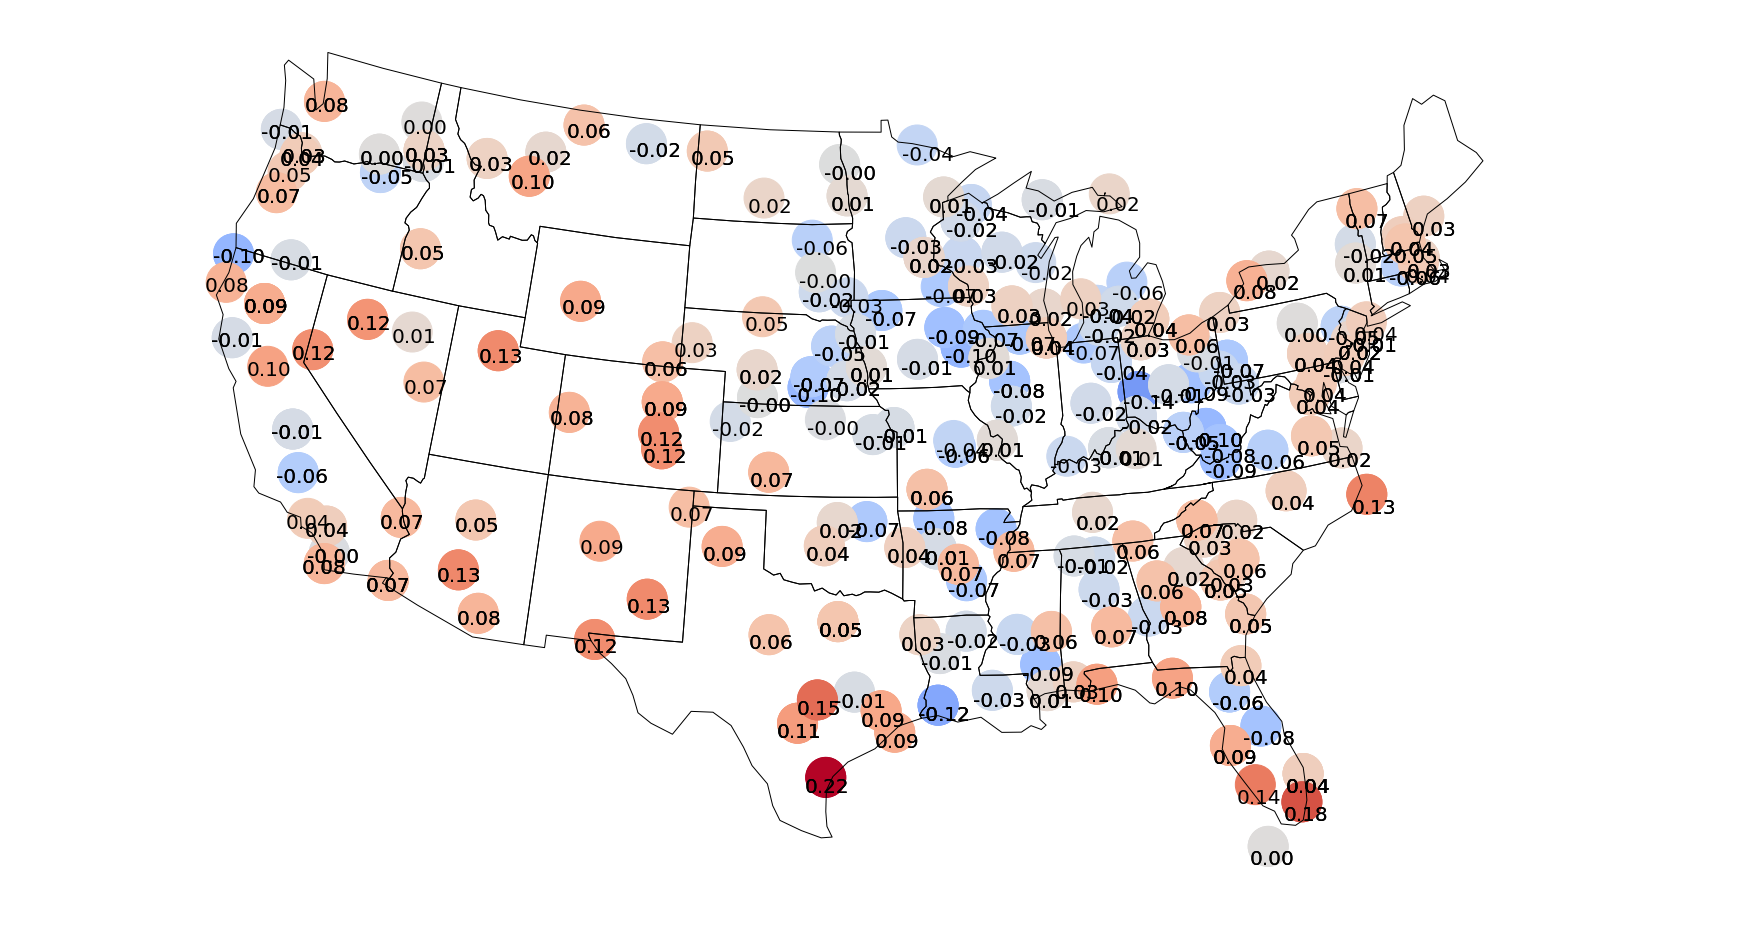

In [6]:
# https://scitools.org.uk/cartopy/docs/latest/gallery/lines_and_polygons/hurricane_katrina.html#sphx-glr-gallery-lines-and-polygons-hurricane-katrina-py
fig = plt.figure()
fig.set_figheight(24)
fig.set_figwidth(24)
# to get the effect of having just the states without a map "background"
# turn off the background patch and axes frame
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(),
                  frameon=False)

ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural', name=shapename)
ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(), facecolor='none')
#    styler=colorize_state)

lon = [c['Lon'] for c in cities]
lat = [c['Lat'] for c in cities]
m = [c['p98_by_year_m'] for c in cities]
ax.scatter(lon, lat, c=m, norm=colors.CenteredNorm(), cmap='coolwarm', marker='o', s=40**2, transform=ccrs.PlateCarree())
for i, slope in enumerate(m):
    ax.text(lon[i]-0.75, lat[i]-0.5, f'{slope:0.2f}', size=20, transform=ccrs.PlateCarree())
None

In [10]:
print(f'{"Name":45s} {"p98":5s}  {"slope":6s} {"1920":5s} {"1945":5s} {"1970":5s} {"1995":5s} {"1920":5s}')
for city in cities:
    _1920 = city["p98_by_year"].get(1920, -1)
    _1945 = city["p98_by_year"].get(1945, -1)
    _1970 = city["p98_by_year"].get(1970, -1)
    _1995 = city["p98_by_year"].get(1995, -1)
    _2020 = city["p98_by_year"].get(2020, -1)
    print(f'{city["Stn.Name"]:44s} {city["p98"]:5.1f}F {city["p98_by_year_m"]:6.3f} {_1920:5d} {_1945:5d} {_1970:5d} {_1995:5d} {_2020:5d}')

Name                                          p98    slope  1920  1945  1970  1995  1920 
DAYTON MCD                                    94.0F -0.140     3     5     3     5     2
DAYTON INTERNATIONAL AIRPORT                  94.0F -0.140     3     5     3     5     2
LAKE CHARLES DOWNTOWN                         97.0F -0.122     2     1     6    20     2
LAKE CHARLES CHENNAULT AIRPORT                97.0F -0.122     2     1     6    20     2
LAKE CHARLES REGIONAL AIRPORT                 97.0F -0.122     2     1     6    20     2
CRESCENT CITY 3NNW                            79.0F -0.102    16     4     3     1     3
CRESCENT CITY MCNAMARA AP                     79.0F -0.102    16     4     3     1     3
Cedar Rapids #1                               95.0F -0.101    14     4     1    13     0
Cedar Rapids AP                               95.0F -0.101    14     4     1    13     0
CHARLESTON 1                                  95.0F -0.098    12    11     1     1     7
INSTITUTE WERTZ FIEL